# **Import**

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import cross_validate

# **23만 데이터**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/머신러닝/연구회_프로젝트/PhiUSIIL_Phishing_URL_Dataset.csv')
df.shape
df['label'].value_counts()

label
1    134850
0    100945
Name: count, dtype: int64

# **입력 파일 정리**


In [3]:
df_1 = df.drop(columns=['FILENAME', 'URL', 'Domain','Title','TLD'])
df_1

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,100.000000,1.000000,0.522907,0.061933,3,1,0,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,100.000000,0.666667,0.032650,0.050207,2,1,0,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,100.000000,0.866667,0.028555,0.064129,2,2,0,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,100.000000,1.000000,0.522907,0.057606,3,1,0,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,100.000000,1.000000,0.079963,0.059441,3,1,0,...,1,0,1,244,15,34,72,1,85,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235790,29,22,0,100.000000,1.000000,0.522907,0.058739,3,1,0,...,1,0,1,51,7,21,187,2,191,1
235791,28,21,0,100.000000,0.785714,0.028555,0.053834,2,2,0,...,1,0,0,50,1,7,88,0,31,1
235792,30,23,0,100.000000,1.000000,0.003319,0.063093,2,1,0,...,0,0,1,27,10,30,58,2,67,1
235793,55,47,0,28.157537,0.465116,0.000961,0.050211,3,2,0,...,0,0,0,0,0,3,0,0,0,0


# **X, y값 지정**

In [4]:
X = df_1.drop(columns=['label'])
X

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
0,31,24,0,100.000000,1.000000,0.522907,0.061933,3,1,0,...,1,0,0,1,34,20,28,119,0,124
1,23,16,0,100.000000,0.666667,0.032650,0.050207,2,1,0,...,0,0,0,1,50,9,8,39,0,217
2,29,22,0,100.000000,0.866667,0.028555,0.064129,2,2,0,...,0,0,0,1,10,2,7,42,2,5
3,26,19,0,100.000000,1.000000,0.522907,0.057606,3,1,0,...,0,1,1,1,3,27,15,22,1,31
4,33,26,0,100.000000,1.000000,0.079963,0.059441,3,1,0,...,1,1,0,1,244,15,34,72,1,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235790,29,22,0,100.000000,1.000000,0.522907,0.058739,3,1,0,...,0,1,0,1,51,7,21,187,2,191
235791,28,21,0,100.000000,0.785714,0.028555,0.053834,2,2,0,...,0,1,0,0,50,1,7,88,0,31
235792,30,23,0,100.000000,1.000000,0.003319,0.063093,2,1,0,...,0,0,0,1,27,10,30,58,2,67
235793,55,47,0,28.157537,0.465116,0.000961,0.050211,3,2,0,...,0,0,0,0,0,0,3,0,0,0


In [5]:
y = df_1['label'].values
y

array([1, 1, 1, ..., 1, 0, 1])

# **데이터 분할**
학습 데이터셋 : 테스트 데이터셋 = 80: 20

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)


# **모델 파라미터 설정 및 loss값 error값 확인**
tree booster Parameter


In [8]:
XGB = XGBClassifier(max_depth=5, reg_lambda=0.1, n_estimators=400, objective='binary:logistic')
evals = [(X_test, y_test)]
XGB.fit(X_train, y_train, early_stopping_rounds=100, eval_metric=["error","logloss"], eval_set=evals, verbose=True)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.00000	validation_0-logloss:0.42756
[1]	validation_0-error:0.00000	validation_0-logloss:0.28935
[2]	validation_0-error:0.00000	validation_0-logloss:0.20247
[3]	validation_0-error:0.00000	validation_0-logloss:0.14436
[4]	validation_0-error:0.00000	validation_0-logloss:0.10414
[5]	validation_0-error:0.00000	validation_0-logloss:0.07572
[6]	validation_0-error:0.00000	validation_0-logloss:0.05534
[7]	validation_0-error:0.00000	validation_0-logloss:0.04060
[8]	validation_0-error:0.00000	validation_0-logloss:0.02987
[9]	validation_0-error:0.00000	validation_0-logloss:0.02202
[10]	validation_0-error:0.00000	validation_0-logloss:0.01625
[11]	validation_0-error:0.00000	validation_0-logloss:0.01201
[12]	validation_0-error:0.00000	validation_0-logloss:0.00888
[13]	validation_0-error:0.00000	validation_0-logloss:0.00657
[14]	validation_0-error:0.00000	validation_0-logloss:0.00487
[15]	validation_0-error:0.00000	validation_0-logloss:0.00360
[16]	validation_0-error:0.00000	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [9]:
y_train_pred = XGB.predict(X_train)
y_test_pred = XGB.predict(X_test)

# **테스트 평가지표**
성능평가
정확도, 오차 행렬, 정밀도, 재현율, F1스코어, ROC AUC

In [10]:
#ROC AUC 계산을 위한 확률 값
y_test_pred_proba = XGB.predict_proba(X_test)[:, 1]

In [11]:
test_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

In [12]:
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Test Accuracy: 1.0
Confusion Matrix:
 [[20209     0]
 [    0 26950]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 0.9999999999999999


In [13]:
print("\n성능 보고서:\n", classification_report(y_test, y_test_pred))


성능 보고서:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20209
           1       1.00      1.00      1.00     26950

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



# **시각화**
ROC Curve, 오차행렬, error, loglooss

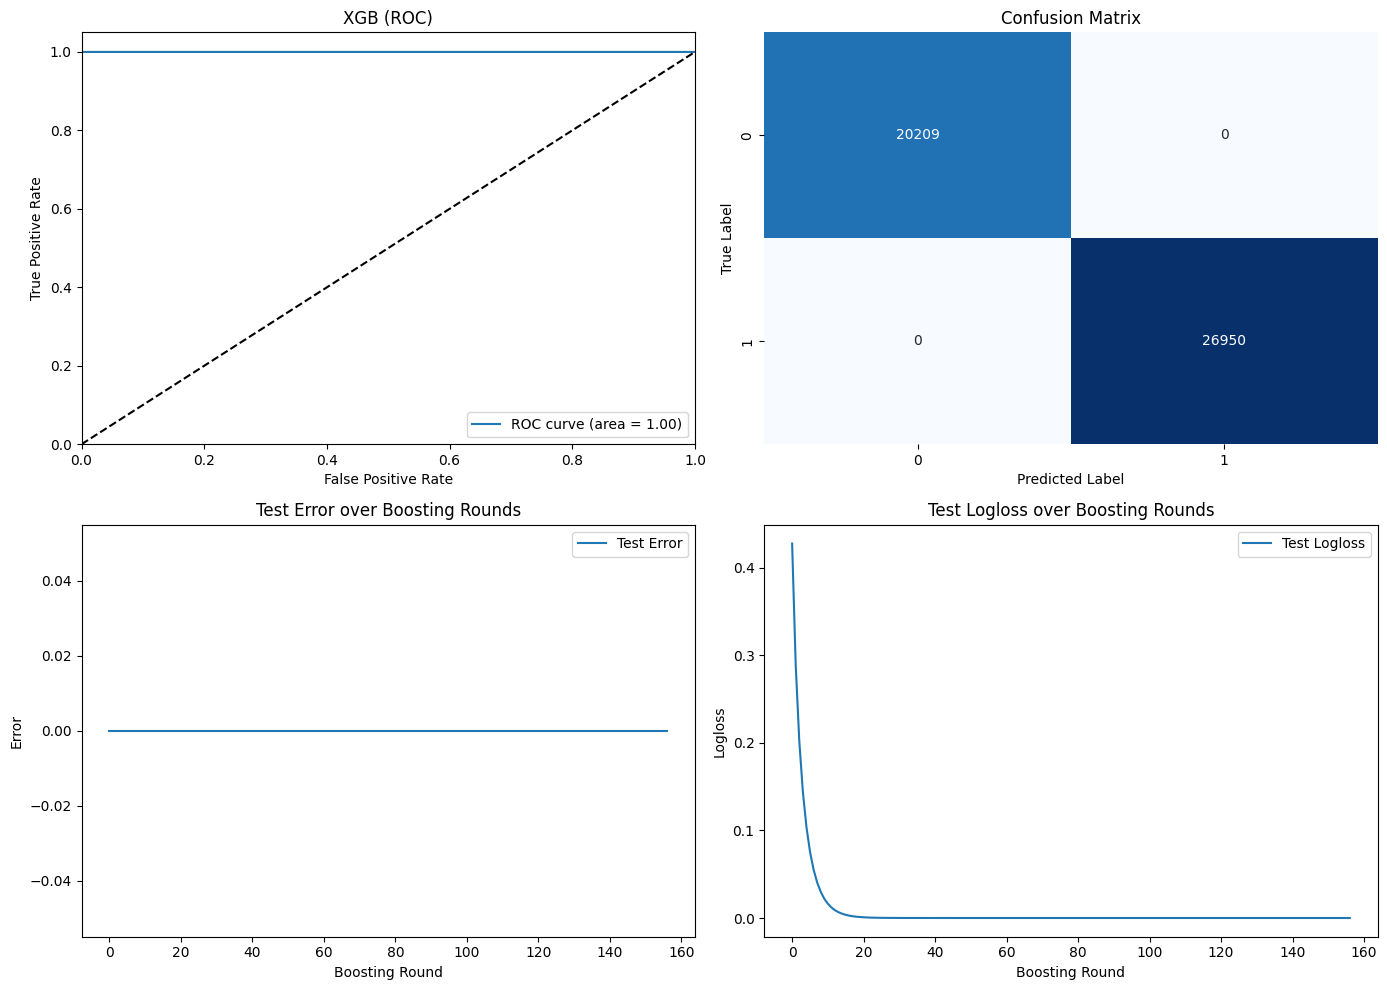

In [14]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(14,10))
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB (ROC)')
plt.legend(loc='lower right')


#오차행렬
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


#에러
results = XGB.evals_result()

plt.subplot(2, 2, 3)
plt.plot(results['validation_0']['error'], label='Test Error')
plt.xlabel('Boosting Round')
plt.ylabel('Error')
plt.title('Test Error over Boosting Rounds')
plt.legend()


# Logloss per iteration
plt.subplot(2, 2, 4)
plt.plot(results['validation_0']['logloss'], label='Test Logloss')
plt.xlabel('Boosting Round')
plt.ylabel('Logloss')
plt.title('Test Logloss over Boosting Rounds')
plt.legend()


plt.tight_layout()
plt.show()

# **상위 특징 10개 추출**

In [15]:
feature_importances = XGB.feature_importances_
top_features = np.argsort(feature_importances)[::-1][:10]
print("Top 10 Features", top_features)

Top 10 Features [ 3 22 21 36 13 44 12 49 47  6]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

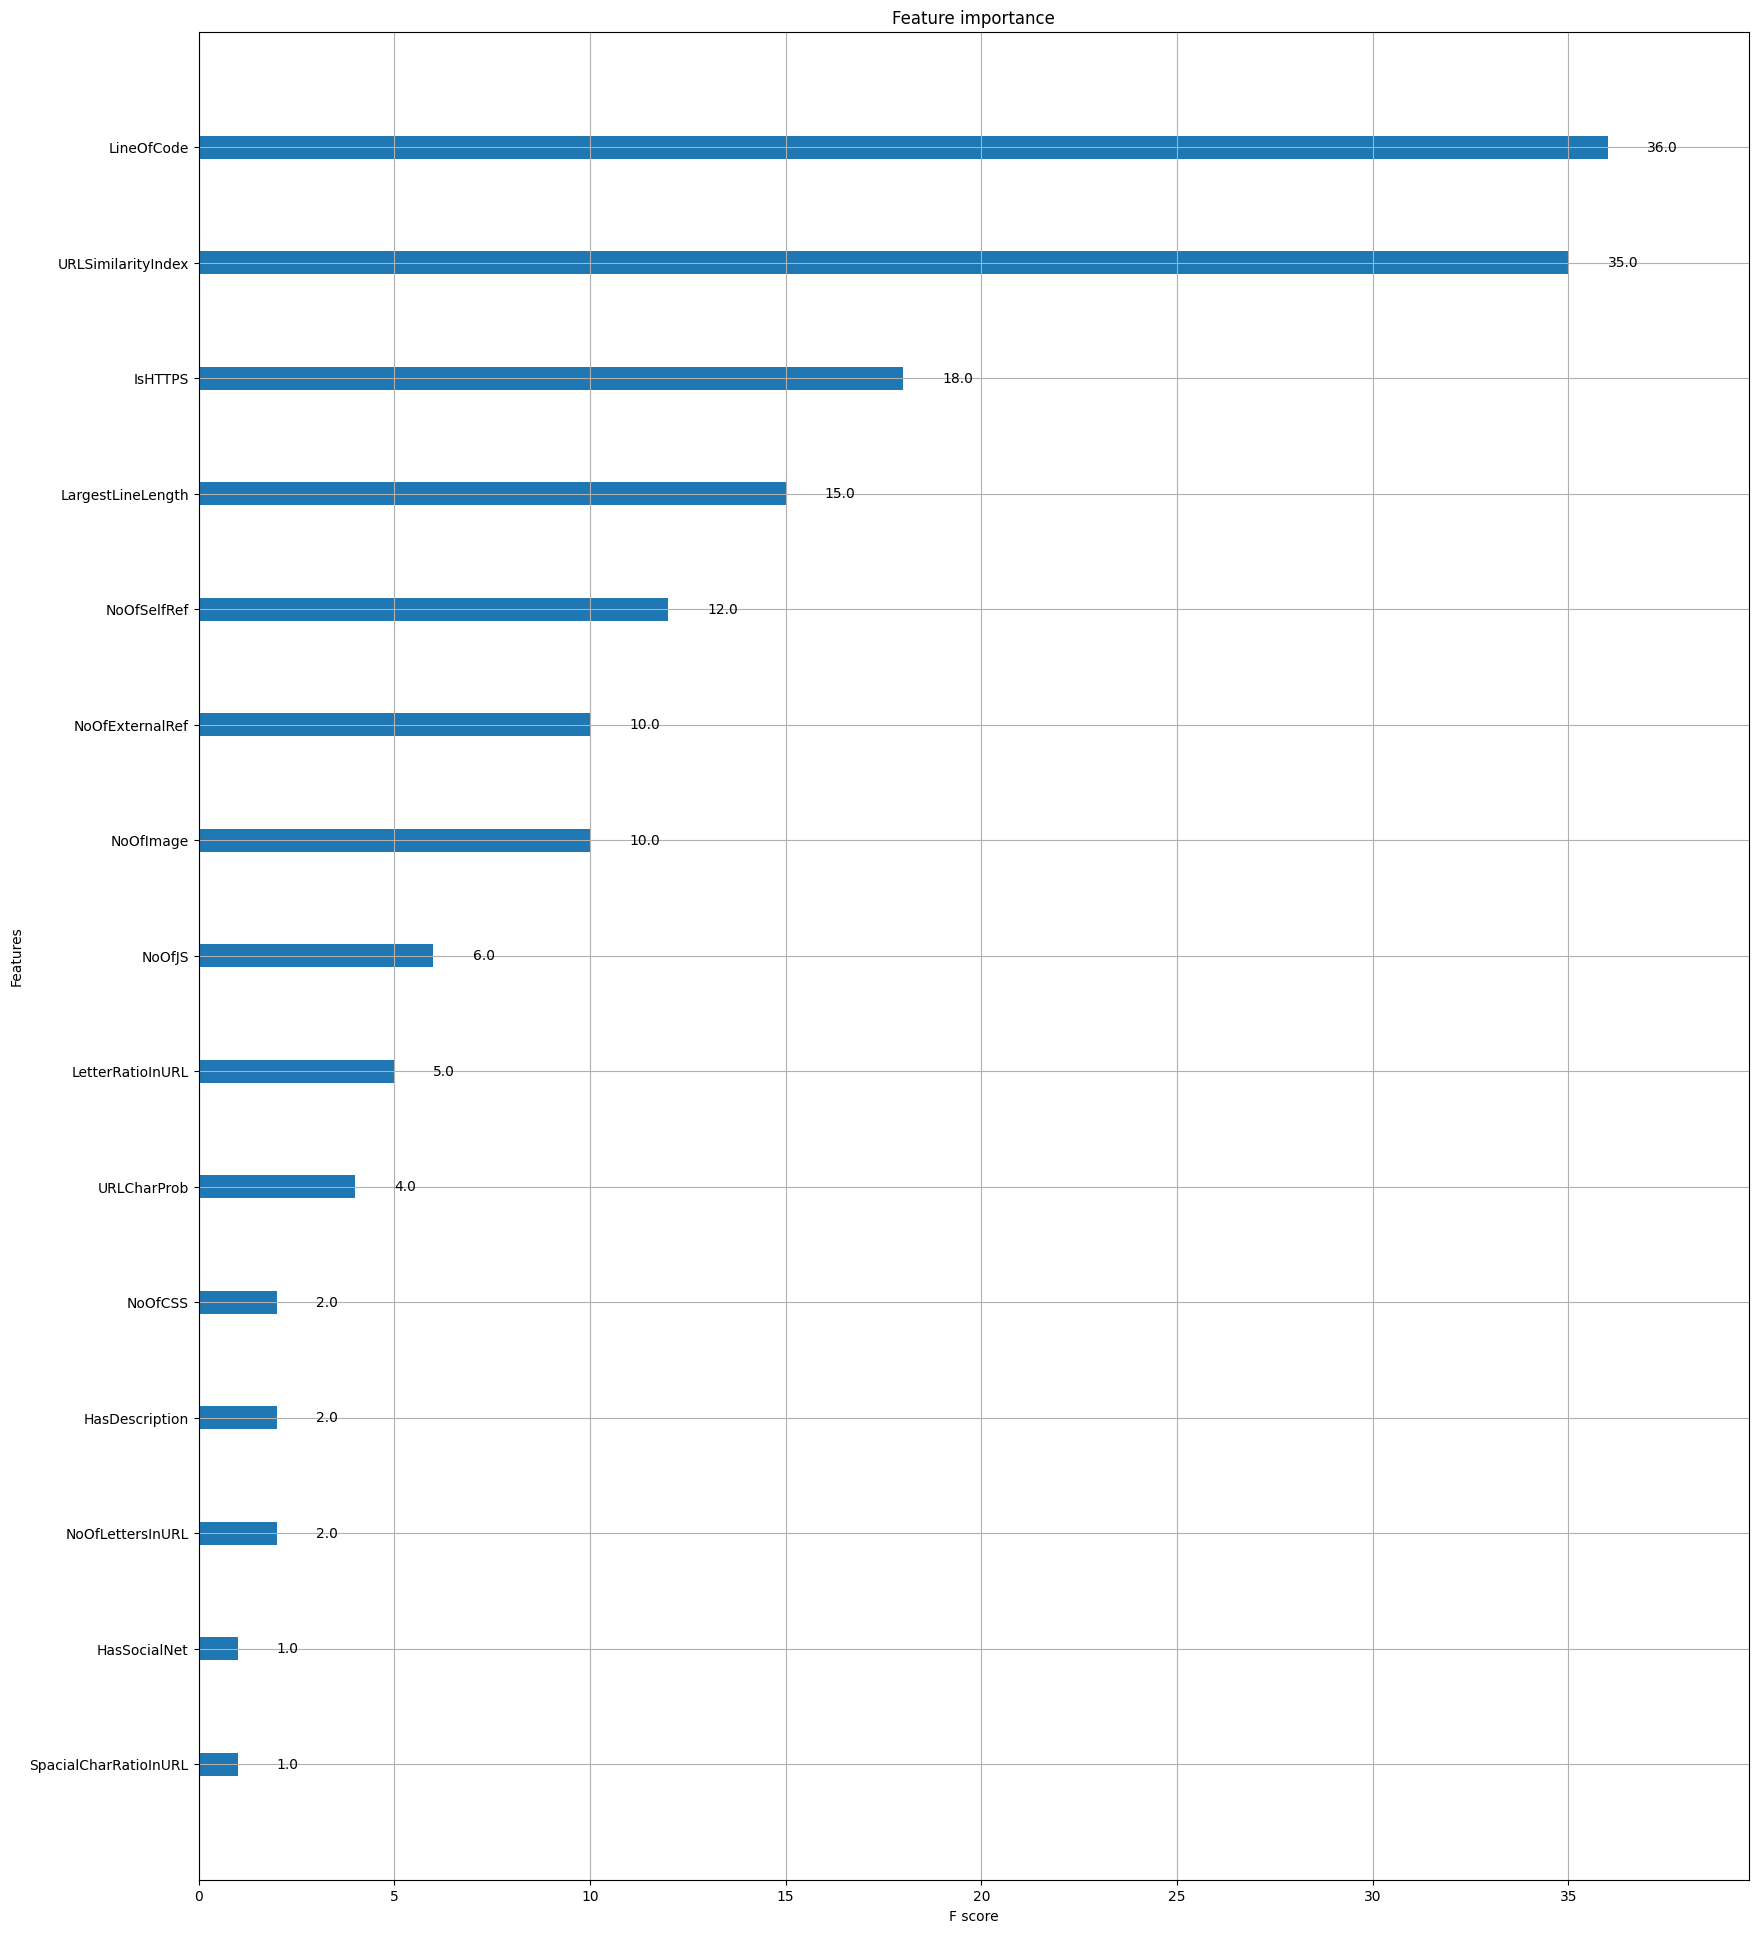

In [16]:
fig, ax = plt.subplots(figsize=(20, 24))
plot_importance(XGB, ax=ax)

# **일반화 및 모델 성능 향상을 위한 하이퍼 파라미터 튜닝**

In [17]:
#우선 교차검증부터 시작
start_time = time.time()
cross_val = cross_validate(
    XGB,
    X,
    y,
    cv=5,
    return_train_score=True,
    scoring='accuracy'
)
end_time = time.time()
total_cross_validation_time = end_time - start_time

#전체 교차 검증 시간 출력
total_cross_validation_time_minutes = total_cross_validation_time / 60
print("총 교차 검증 시간(분) :", total_cross_validation_time_minutes)
# 전체 교차 검증 점수 출력
print("훈련 점수:", np.mean(cross_val['train_score']))
print("검증 점수:", np.mean(cross_val['test_score']))

총 교차 검증 시간(분) : 1.0208104809125265
훈련 점수: 1.0
검증 점수: 0.9999957590279692


In [ ]:
#하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV
n_XGB = XGBClassifier(random_state=10)
param_grid = {
    'n_estimators': [1000, 2000, 3000],
    'max_depth':[None, 10, 30],
    'min_child_weight': [1, 2, 3, 5, 7, 10],
    'gamma': [0, 0.1, 0.2, 0.3,],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
    'colsample_bytree': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
}
grid_search = GridSearchCV(n_XGB, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
best_params = grid_search.best_params_


In [ ]:
print("Best Parameters:", best_params)


In [19]:
# XGBClasifier 초기화
param = {
    'n_estimators': 1000,
    'max_depth': None,
    'learning_rate': 0.3,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.5,
    'colsample_bytree': 0.55
    }
XGB_Best = xgb.XGBClassifier(**param)
# 모델 훈련 및 평가
eval_set = [(X_train, y_train), (X_test, y_test)]
XGB_Best.fit(X_train, y_train, early_stopping_rounds=700, eval_set=eval_set, eval_metric=["error", "logloss"], verbose=True)
# validation_0 = Train, validation_1 = Test

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.00010	validation_0-logloss:0.42760	validation_1-error:0.00006	validation_1-logloss:0.42766
[1]	validation_0-error:0.00013	validation_0-logloss:0.28947	validation_1-error:0.00006	validation_1-logloss:0.28949
[2]	validation_0-error:0.00008	validation_0-logloss:0.20472	validation_1-error:0.00004	validation_1-logloss:0.20464
[3]	validation_0-error:0.00007	validation_0-logloss:0.14676	validation_1-error:0.00004	validation_1-logloss:0.14672
[4]	validation_0-error:0.00014	validation_0-logloss:0.10679	validation_1-error:0.00008	validation_1-logloss:0.10679
[5]	validation_0-error:0.00011	validation_0-logloss:0.07836	validation_1-error:0.00006	validation_1-logloss:0.07837
[6]	validation_0-error:0.00012	validation_0-logloss:0.05798	validation_1-error:0.00011	validation_1-logloss:0.05802
[7]	validation_0-error:0.00005	validation_0-logloss:0.04253	validation_1-error:0.00004	validation_1-logloss:0.04256
[8]	validation_0-error:0.00005	validation_0-logloss:0.03183	validation_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.55, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
# 에러 값, 손실 값, 최종 점수 확인
evals_result = XGB_Best.evals_result()
train_error = evals_result['validation_0']['error']
test_error = evals_result['validation_1']['error']
train_loss = evals_result['validation_0']['logloss']
test_loss = evals_result['validation_1']['logloss']
final_score = XGB_Best.score(X_test, y_test)
print("Train Error:", [f"{error:.4f}" for error in train_error])
print("Test Error:", [f"{error:.4f}" for error in test_error])
print("Train Loss:", [f"{loss:.4f}" for loss in train_loss])
print("Test Loss:", [f"{loss:.4f}" for loss in test_loss])
print("Final Score:", final_score)

Train Error: ['0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0000', '0.0001', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.000

# **시각화**

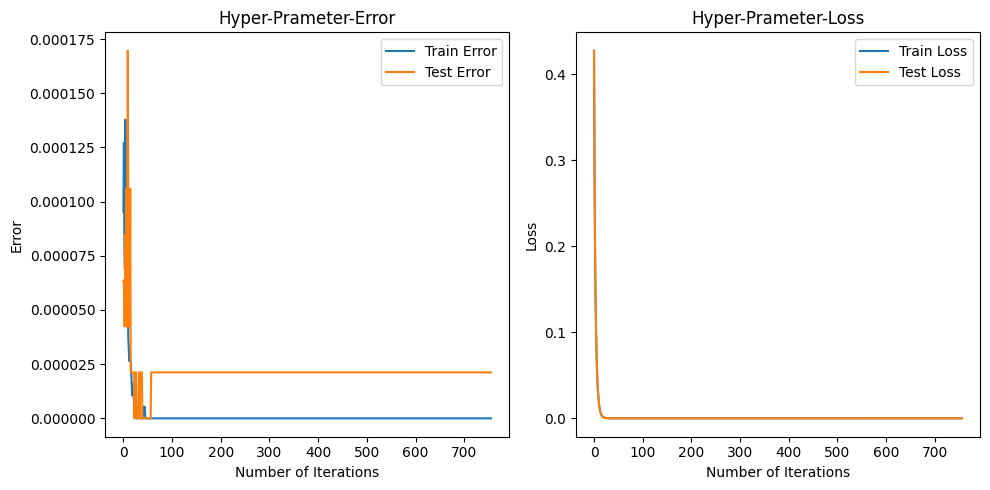

In [21]:
# 시각화
plt.figure(figsize=(10, 5))

# 에러 값 그래프
plt.subplot(1, 2, 1)
plt.plot(train_error, label='Train Error')
plt.plot(test_error, label='Test Error')
plt.xlabel('Number of Iterations')
plt.ylabel('Error')
plt.title('Hyper-Prameter-Error')
plt.legend()

# 손실 값 그래프
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Hyper-Prameter-Loss')
plt.legend()

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

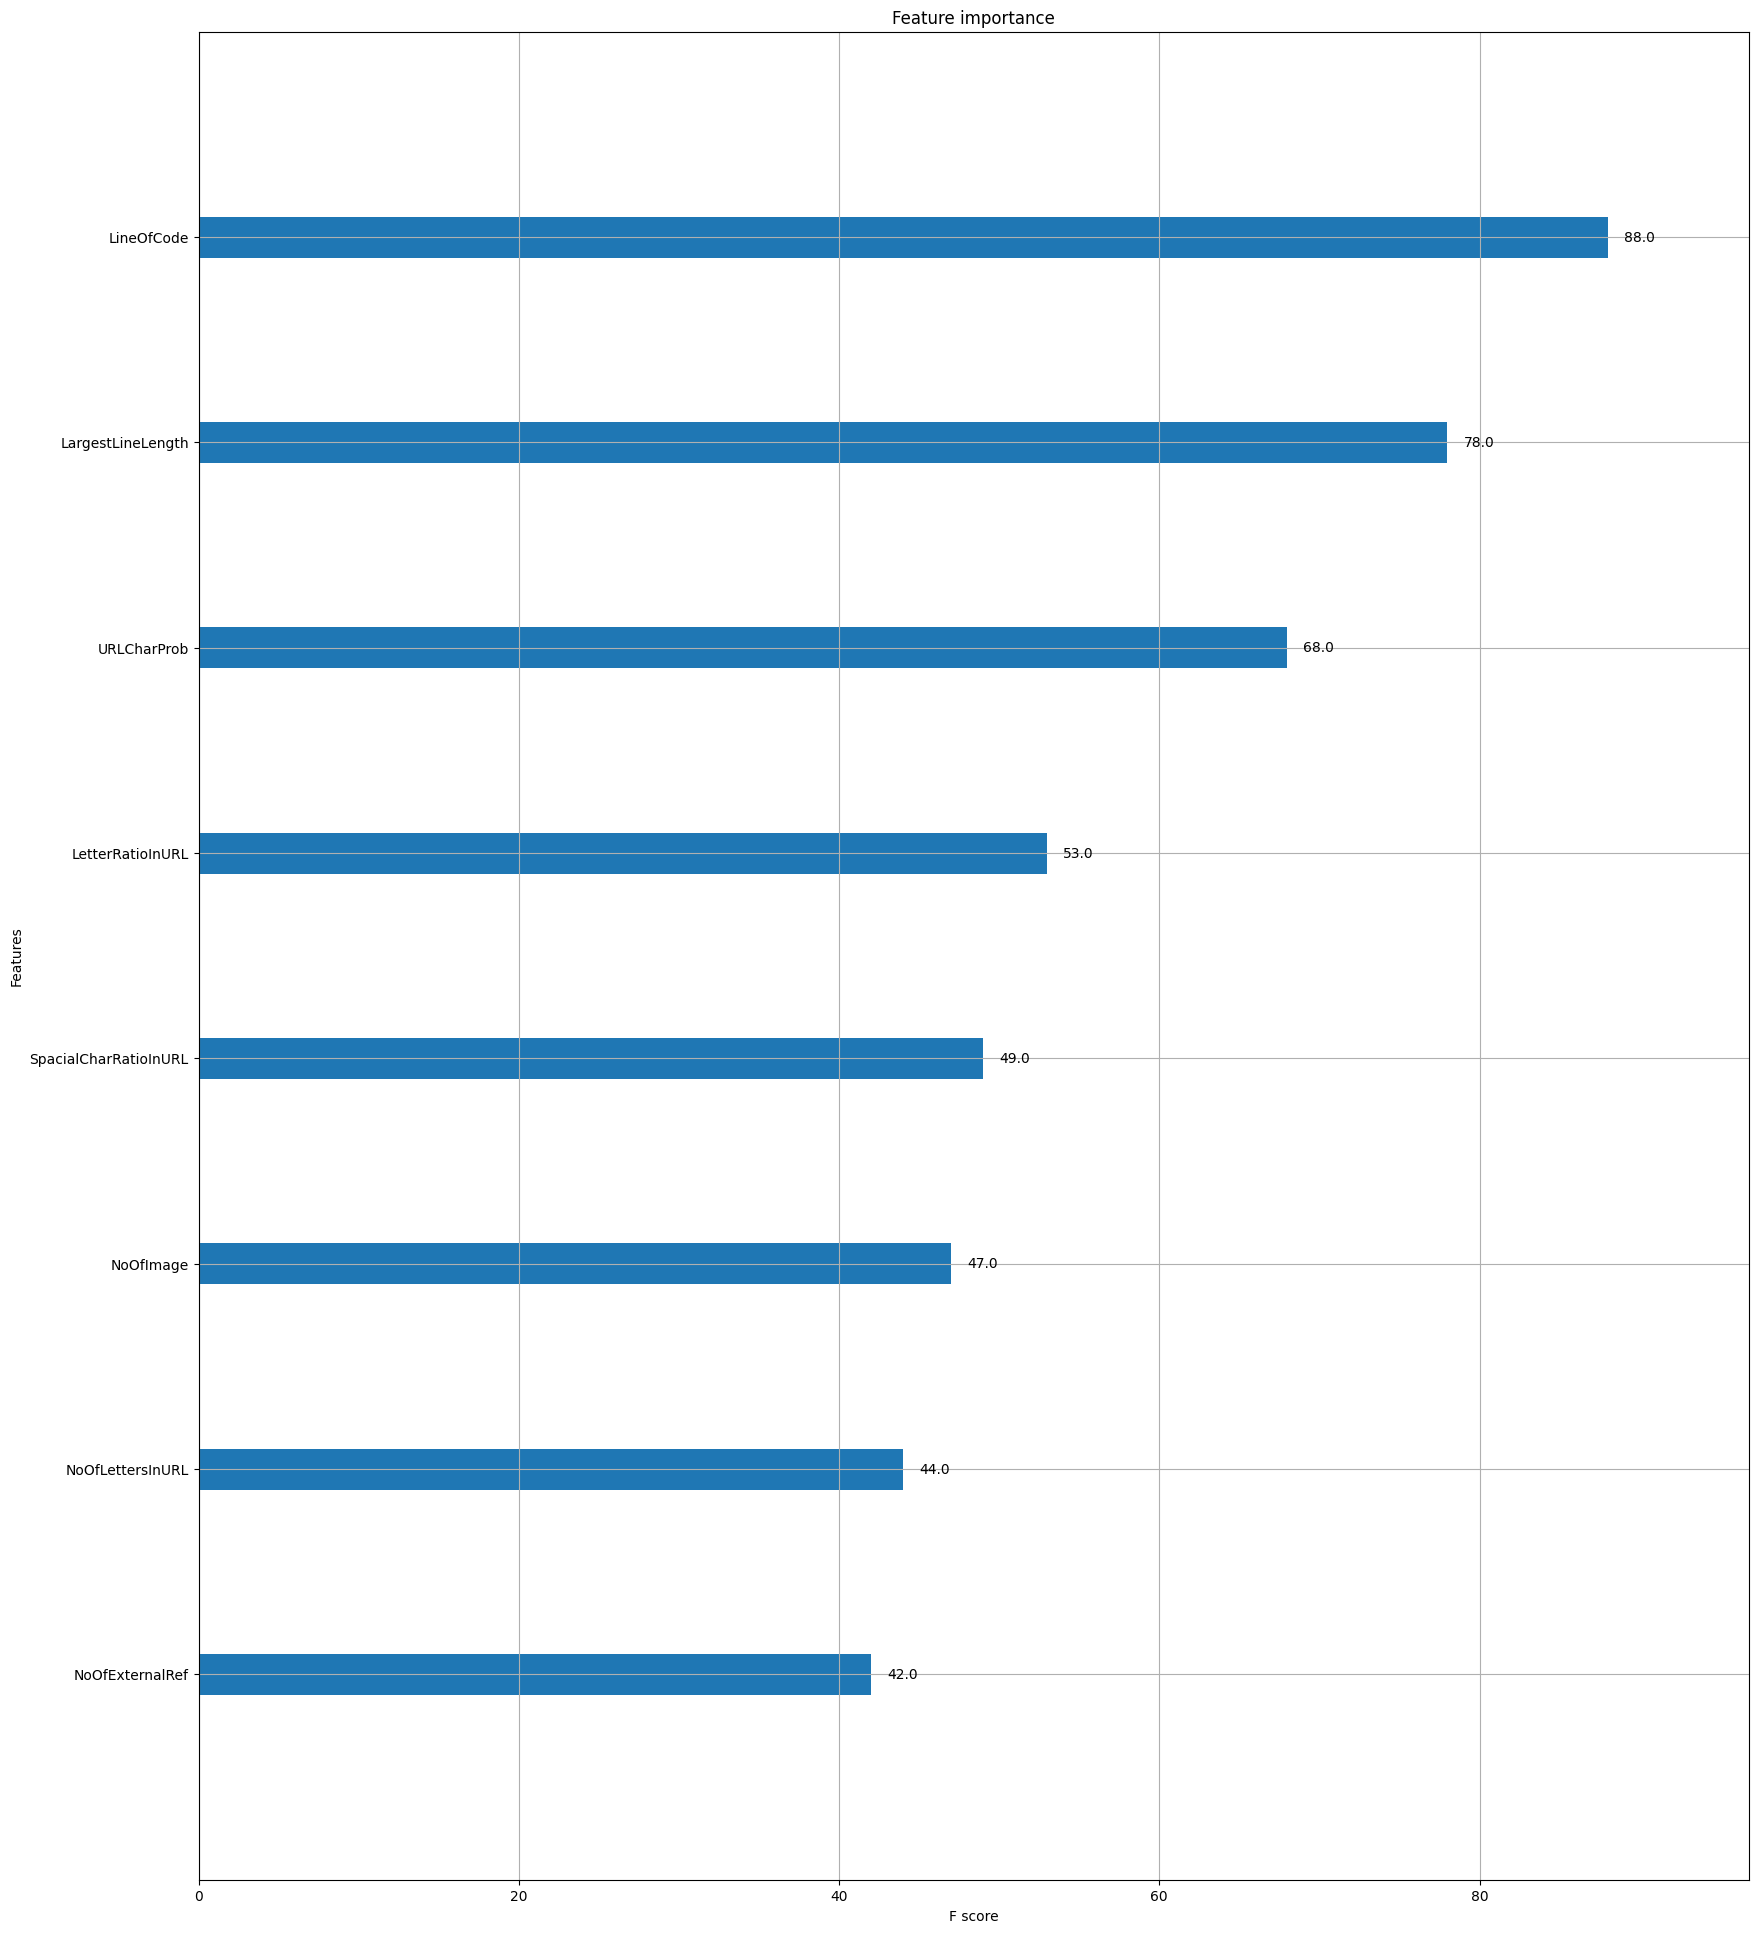

In [22]:
fig, ax = plt.subplots(figsize=(20, 24))
plot_importance(XGB_Best, ax=ax, max_num_features=8)